# Neural likelihood-free inference

BSc ML course, Sep 2020

Author: Christoph Weniger



## Initialization

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pylab as plt
import numpy as np
from tqdm import tqdm
import random

## Exercise 0 - Bayes theorem applications



Bayes theorem is
$$
P(H|D) = \frac{P(D|H) P(H)}{P(D)}
$$
where the $P(H|D)$ is the posterior probability of hypothesis $H$ being true given data $D$, $P(D|H)$ is the probability (likelihood) of observing data $D$ given hypothesis $H$, $P(H)$ is your prior believ in hypothesis $H$, and $P(D) \equiv \sum_H P(D|H) P(H)$ is the so-called Bayesian evidence, which acts as normalizing factor for the posterior.  If there are a continuous number of hypothesis $H$, the sum would be replaced by an integral.


### Task A) Basics

Show that the posterior probability distribution is normalized to one per definition.


Solution: Just sum over $H$.


### Task B) Drug trafficking statistics

Consider the border control chasing drug trafficking at a German train station close to Kerkrade.  The probability that a random person on the train station carries drugs is $1/300$.  Among the persons carrying drugs 80\% react nervous when they encounter border control.  Only 3\% of them carry big luggage.  Persons without drugs react only in $10\%$ of the cases nervous when they encounter border control, and carry big luggage in 90\% of the cases.  How many nervous people without big luggage does the border control have to check on average to find drugs?

Hint: The prior probability of a person carying drugs (hypothesis $H_d$) is $P(H_d) = 1/300$, the prior probability of a person being clean (hypothesis $H_c$) is $P(H_c) = 299/300$.





In [ ]:
# Solution

PHd = 1/300
PHc = 299/300
P_N_Hd = 0.8
P_N_Hc = 0.1
P_nL_Hd = 1-0.03
P_nL_Hc = 1-0.90
P_Hd_N_nL = (P_N_Hd*P_nL_Hd*PHd)/(P_N_Hd*P_nL_Hd*PHd + P_N_Hc*P_nL_Hc*PHc)
print("Probability of a nervous person without big lauggage carrying drugs:", P_Hd_N_nL)
print("Number of controls necessary to find around one:", 1/P_Hd_N_nL)

Probability of a nervous person without big lauggage carrying drugs: 0.20605416887944772
Number of controls necessary to find around one: 4.853092783505154


## Exercise 1 - A toy strong lensing image

Our "simulator" produces images with one or more rings, where the radius, the width and the number of rings can be modified.  Think of this model as a very simple toy model for producing for instance images of graviationally lensed systems.  The radius would then correspond to the "Einstein radius" of the gravitational lensing system and tell us something about the mass of the lensing galaxy. The width would correspond to the size of the lensed source galaxy.  Normally, you would not get multiple rings in one image, but in our toy model we do, to make it a mit more difficult for the networks to learn the parameters.

A real strong lensing image looks like this:

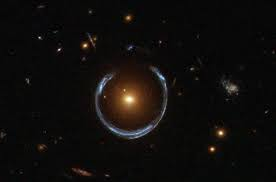


In [ ]:
def image_model(radius = 0.5, sigma = 0.1, width = 0.15, n = 1):
    x = np.linspace(-2, 2, 32)
    X, Y = np.meshgrid(x, x)
    
    # Random position of the ring
    imgs = []
    for i in range(n):
      x0, y0 = np.random.uniform(-1, 1, 2)

      R = ((X-x0)**2 + (Y-y0)**2)**0.5
      img = np.exp(-(R-radius)**2/width**2/2)
      img = img

      imgs.append(img)
    
    # Standard variance and zero mean
    img = sum(imgs)

    # Add image noise
    img += np.random.randn(*img.shape)*sigma

    # Remove mean and variance, which makes it easier to train for the NN
    img -= img.mean()
    img /= img.std()
    return img

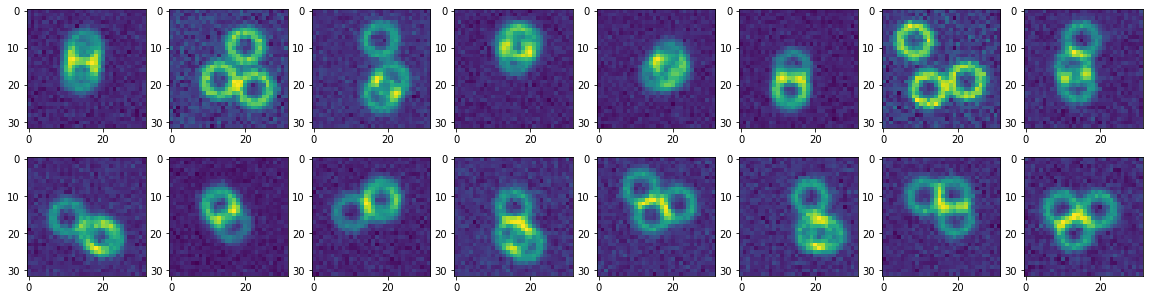

In [ ]:
# A bunch of examples

plt.figure(figsize=(20, 5))
for i in range(16):
  plt.subplot(2, 8, i+1)
  img = image_model(radius = 0.5, width = 0.15, n = 3)
  plt.imshow(img)

### Task A) The image model.

Play with radius, width and $n$ and see how the images change.  For what values of the width do you expect that it becomes impossible to measure the radius or number of rings?

Solution: For the default values of n and the radius, widths above 0.5 blur everything together so that discrimination should become hard.

### Parameter priors

In later exercises, we will create images for a range of parameters.  Those parameters are randomly drawn in the function below.

In [ ]:
def draw_from_prior():
    # returns random draw from p(z)
    radius = np.random.uniform(0.5, 1.5)
    width = np.random.uniform(0.1, 1.0)
    return {'radius': radius, 'width': width}

## Exercise 2 - Parameter regression

Goal is to train a network that estimates the radius of the rings in images.  We will obtain a function:

radius = NN(image).



### Convolutional neural network 

We define here a standard convolutional neural network with two convolutional layers and three dense layers at the bottom.  The forward function takes as argument an image ($x$), and returns a single number (the radius).


In [ ]:
class RegressionCNN(nn.Module):
    def __init__(self):
        super(RegressionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, 3)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.fc1 = nn.Linear(40, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 1)
        self.pool = nn.MaxPool2d(3)

    def forward(self, x):
        x = x.unsqueeze(0).unsqueeze(0)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.flatten() 

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x

### The training algorithm

The below training loop runs through many (image, radius) pairs and optimizes the predictions of the network `net` such that the predicted matches the actual ring radius.

100%|██████████| 4000/4000 [00:25<00:00, 155.27it/s]


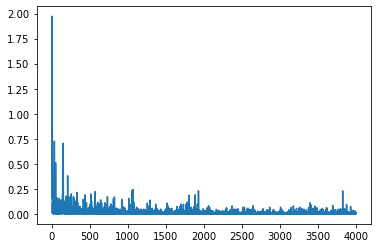

In [ ]:
# Initialize network
net = RegressionCNN()
optimizer = optim.Adam(net.parameters(), lr = 1e-3)
loss_history = []

# Training network
net.train()  # Set network to training mode
Niter = 4000  # Number of training iterations

for i in tqdm(range(Niter)):
    optimizer.zero_grad()  # Reset internal gradients

    radius_true = draw_from_prior()['radius']
    img = model(radius = radius_true, n = 1)

    img = torch.tensor(img).float()
    
    radius_estimated = net(img)
    
    # Training minimizes the loss function
    loss = (radius_estimated - radius_true)**2
    loss_history.append(loss)

    loss.backward()
    optimizer.step()

plt.plot(loss_history)

### Testing the reconstruction accuracy

We now can compare the predictions of the network with the ground truth.

Text(0, 0.5, 'Estimated radius')

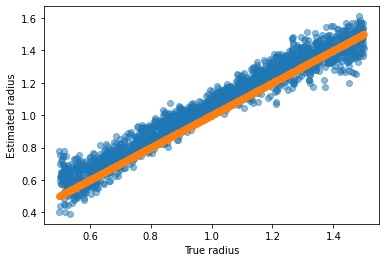

In [ ]:
true, pred = [], []
for i in range(2000):
  r_true = draw_from_prior()['radius']
  img = model(radius = r_true, n = 1)
  img = torch.tensor(img).float()
  r_pred = net(img).detach()
  true.append(r_true)
  pred.append(r_pred.numpy())
plt.scatter(true, pred, alpha = 0.5)
plt.scatter(true, true, alpha = 0.5)
plt.xlabel("True radius")
plt.ylabel("Estimated radius")

### Task A) Explore how training parameters affect the fit

- Explore what is the minimum number of training iterations required to get reasonable results.

- What happens if the learning rate is too large?  What happens if the learning rate is too small?



### Task B) Generalization

- The network is trained on images with one ring ($n=1$).  It also works for images with multiple rings to some degree.  When does this break down?

### Task C) Width reconstruction

- Now write a training loop that instead of the radius reconstructes the width.

## Exercise 3 - Classification

Above, we were performing parameter estimation. Now we consider a simple classification problem.  The goal is to train a network to tell use whether a specific image has 4 or 5 rings.

### Generative model

The model now just takes a class label (0 or 1), and returns images with either 4 or 5 rings.

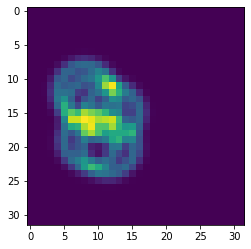

In [ ]:
def model_clas(c):
    n = 4 + c
    img = model(radius = 0.5, n = n, width = 0.1)
    return img

img = model_clas(1)
plt.imshow(img)

### Classification network

The network here has the same structure as the one used above for regression. The only difference is that at the end we mapp the output parameter onto the interval (0, 1).  This will allow us to interpret the output $p = NN(img)$ as the probability that the input image corresponds to class 0.  The probability that the image belongs to class 1 is then simply $1-p$.


In [ ]:
class ClassificationCNN(nn.Module):
    def __init__(self):
        super(ClassificationCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, 3)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.fc1 = nn.Linear(40, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 1)
        self.pool = nn.MaxPool2d(3)

    def forward(self, x):
        x = x.unsqueeze(0).unsqueeze(0)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.flatten() 

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        x = torch.sigmoid(x)  # We use sigmoid to map onto (0, 1)

        return x

100%|██████████| 1000/1000 [00:08<00:00, 123.58it/s]


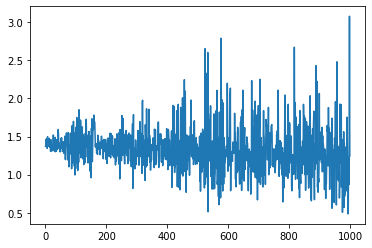

In [ ]:
# Initialize network
netC = ClassificationCNN()
optimizer = optim.Adam(netC.parameters(), lr = 1e-3)
loss_history = []

# Training network
netC.train()  # Set network to training mode
Niter = 1000  # Number of training iterations

for i in tqdm(range(Niter)):
    optimizer.zero_grad()  # Reset internal gradients

    img0 = model_clas(0)  # Image with 4 rings
    img1 = model_clas(1)  # Image with 5 rings

    img0 = torch.tensor(img0).float()
    img1 = torch.tensor(img1).float()
    
    p0 = netC(img0)
    p1 = netC(img1)

    # Binary cross-entropy loss function
    loss = -torch.log(p0) - torch.log(1-p1)
    
    # Training minimizes the loss function
    loss_history.append(loss)

    loss.backward()
    optimizer.step()

plt.plot(loss_history)

### Plotting of validation results

Probability 4 rings: 0.24
Probability 5 rings: 0.76


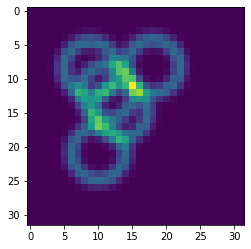

In [ ]:
img0 = model_clas(1)  # Image with 4 rings

plt.imshow(img0)

img0 = torch.tensor(img0).float()
p0 = netC(img0).detach().numpy()[0]

print("Probability 4 rings: %.2f"%p0)
print("Probability 5 rings: %.2f"%(1-p0))

### Task A) Probabilities

- Generate a few examples (by trial and error) and discuss why in some cases the network predictions are clear (with one class being clearly more probable than the other), while in other cases they are more uncertain


### Task B) Larger ring number

- Increase and decrease the number of rings (e.g., 2 vs 3 rings, or 9 vs 10 rings) and show that this makes the network predictions more or less uncertain.

## Exercise 4 - Posterior estimation

Up to now, we considered a regression problem and a classificaiton problem.  In the case of the regression problem, we only got a single number estimator for the radius, without any information about the uncertainty of that prediction.

However, for the classification problem, we actually obtained probabilities, and could see that these probabilities (or uncertainties of the classification) can drastically change depending on how clearly the number of rings in a specific image can be recognized.

Here, we will try to bring both ideas together, and train a network that gives us posterior distributions for parameters.

### Likelihood-to-evidence ratio estimation

As discussed in the lecture, the main idea of likelihood-to-evidence ratio estimation is to train a classification network that can discriminate two hypothesis (or two "classes"):

$H_0$: The (image, radius) pair belong together

$H_1$: The (image, radius) pair are random.

Technicall, we can generate examples for $H_0$ by first generating a random radius, and then the corresponding image.


Text(0.5, 1.0, 'Radius: 1.252')

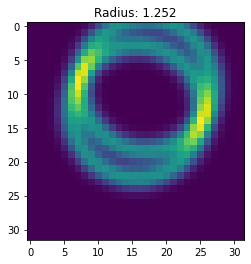

In [ ]:
radius = draw_from_prior()["radius"]
img = model(radius = radius, n = 2)
plt.imshow(img)
plt.title("Radius: %.3f"%radius)

We can generate examples for $H_1$ by first generating a random image (with some random radius), and pair this up with another unrelated radius

Text(0.5, 1.0, 'Radius: 1.204')

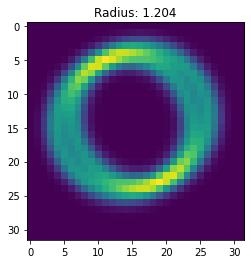

In [ ]:
radius = draw_from_prior()["radius"]
img = model(radius = radius, n = 2)
radius = draw_from_prior()["radius"]

plt.imshow(img)
plt.title("Radius: %.3f"%radius)

In [ ]:
class RatioCNN(nn.Module):
    def __init__(self):
        super(RatioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, 3)
        self.conv2 = nn.Conv2d(5, 10, 3)
        self.fc1 = nn.Linear(41, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 1)
        self.pool = nn.MaxPool2d(3)

    def forward(self, x, z):
        x = x.unsqueeze(0).unsqueeze(0)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = x.flatten() 

        x = torch.cat([x, z.unsqueeze(0)])

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        x = torch.sigmoid(x)  # We use sigmoid to map onto (0, 1)

        return x

100%|██████████| 10000/10000 [01:31<00:00, 109.53it/s]


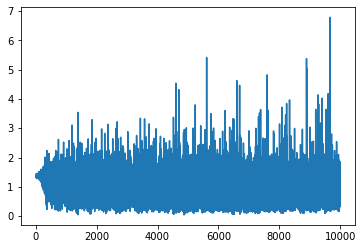

In [ ]:
# Initialize network
netR = RatioCNN()
optimizer = optim.Adam(netR.parameters(), lr = 1e-3)
loss_history = []

# Training network
netR.train()  # Set network to training mode
Niter = 10000  # Number of training iterations

for i in tqdm(range(Niter)):
    optimizer.zero_grad()  # Reset internal gradients

    r_true  = draw_from_prior()['radius']
    r_false = draw_from_prior()['radius']

    img = model(radius = r_true, n = 3)

    img = torch.tensor(img).float()
    r_true = torch.tensor(r_true)
    r_false = torch.tensor(r_false)
    
    d_true = netR(img, r_true)
    d_false = netR(img, r_false)

    # Binary cross-entropy loss function
    loss = -torch.log(d_true) - torch.log(1-d_false)
    
    # Training minimizes the loss function
    loss_history.append(loss)

    loss.backward()
    optimizer.step()

plt.plot(loss_history)

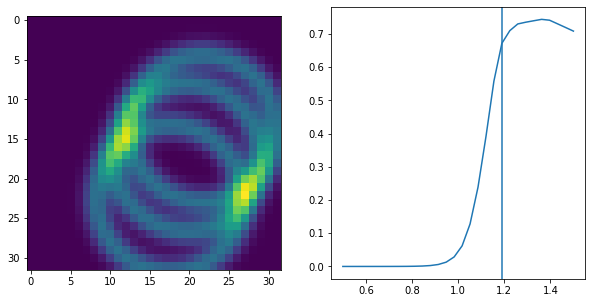

In [ ]:
r_true  = draw_from_prior()['radius']
img = model(radius = r_true, n = 3)

plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.imshow(img)

img = torch.tensor(img).float()
r_true = torch.tensor(r_true)

rlist = np.linspace(0.5, 1.5, 30)
dlist = []
for r in rlist:
    r = torch.tensor(r).float()
    d = netR(img, r).detach().numpy()[0]
    dlist.append(d)

plt.subplot(122)
plt.plot(rlist, dlist)
plt.axvline(r_true)

### Task A) Explore posteriors

- Generate 10 examples like above and confirm that the true radius lies usually within the range of the posterior.
- Try to identify edge cases where the posterior uncertainty is large.
- Change the width of the rings, or the number of the rings, and show that the measurement uncertainty of the ring width increases for more ambiguous images.